In [1]:
import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE

2025-05-27 17:17:13.982826: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 17:17:13.986006: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 17:17:13.995614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748359034.012143   27883 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748359034.016844   27883 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748359034.029493   27883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
dataset_dir = '../data/SmallPreprocessed/'
image_height = 256
image_width = 256
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'val'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

for ds in [train_ds, test_ds, val_ds]:
    ds.cache()
    ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 12000 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.


2025-05-27 17:17:16.917237: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 2000 files belonging to 4 classes.


In [3]:
model = keras.models.Sequential()
model.add(
    tf.keras.applications.VGG16(
        input_shape = (image_height, image_width, 3),
        include_top = False,
        pooling = 'avg',
        weights = 'imagenet'))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,881,924 (68.21 MB)

 Trainable params: 3,160,068 (12.05 MB)

 Non-trainable params: 14,721,856 (56.16 MB)

In [4]:
checkpoint_cb = ModelCheckpoint(
    "model_VGG16.keras",
    save_best_only = True)

early_stopping_cb = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [5]:
EPOCHS = 2

In [6]:
hist = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 1582s 2s/step - accuracy: 0.6277 - loss: 1.3217 - val_accuracy: 0.7995 - val_loss: 0.4925
Epoch 2/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 1550s 2s/step - accuracy: 0.8026 - loss: 0.5000 - val_accuracy: 0.8425 - val_loss: 0.3927


In [7]:
model.save('../models/vgg16_model.keras')
model.export('../models/vgg16_model')

INFO:tensorflow:Assets written to: ../models/vgg16_model/assets


INFO:tensorflow:Assets written to: ../models/vgg16_model/assets


Saved artifact at '../models/vgg16_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139933041055248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988592336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988592912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988594832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988594064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988594256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988593872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988592720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988595408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932988594448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932

In [8]:
score, acc= model.evaluate(test_ds)
print('Val Loss =', score)
print('Val Accuracy =', acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8765 - loss: 0.3435
Val Loss = 0.41071489453315735
Val Accuracy = 0.8395000100135803


In [9]:
hist_=pd.DataFrame(hist.history)

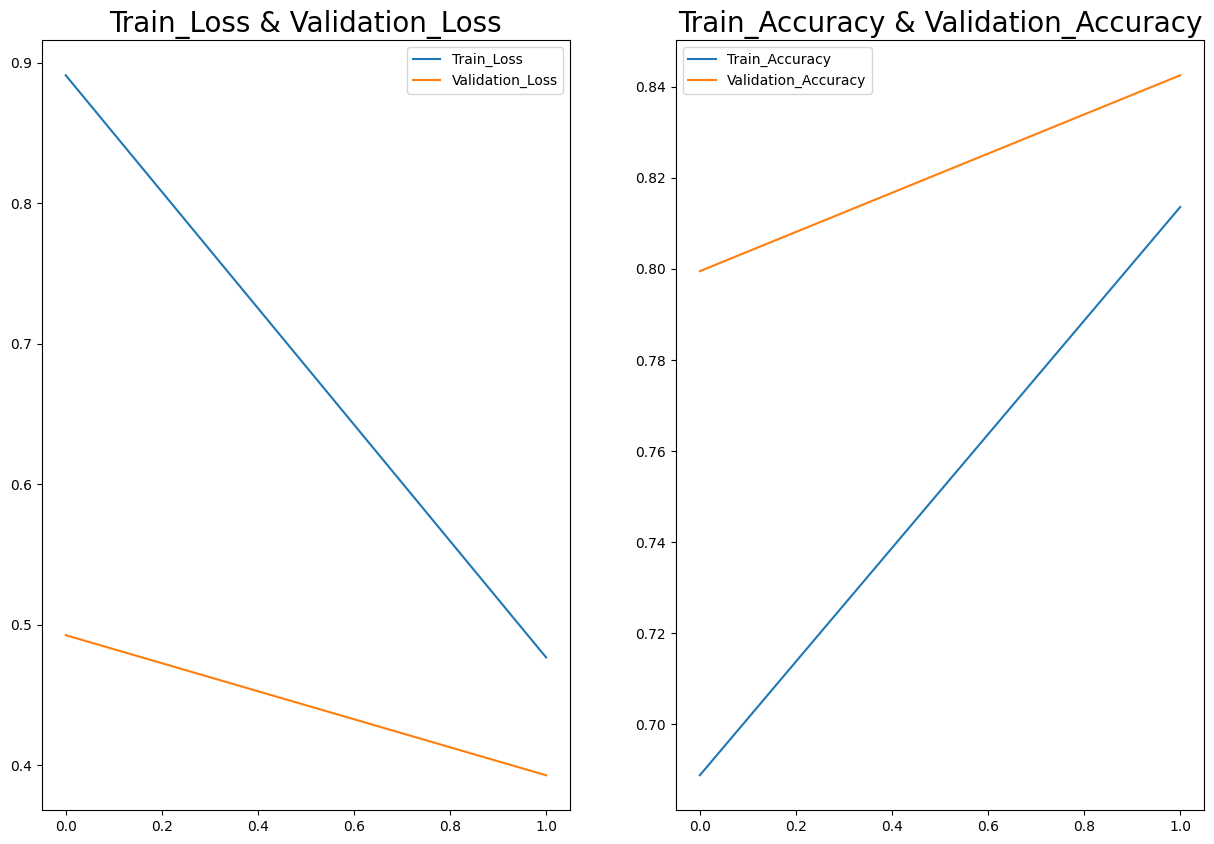

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [14]:
y_test_labels = []
for batch in test_ds:
    images, labels = batch
    y_test_labels.append(labels.numpy())

y_test = np.concatenate(y_test_labels, axis = 0)

predictions = model.predict(test_ds)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

2025-05-27 18:25:32.748231: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step


ValueError: All arrays must be of the same length

In [ ]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)